In [1]:
# Data Manipulation
import pandas as pd
import numpy as np
import re
import os
import io
import json
import ast

# Natural Language Processing
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sentence_transformers import SentenceTransformer

# Statistical Analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Clustering
from sklearn.cluster import KMeans, DBSCAN

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import squarify
import plotly.express as px
import ruptures as rpt

# Geospatial Analysis
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt

# External Services
import boto3
import scienceplots

# IPython Configuration for interactive output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# import pyplot_themes as themes

## Load data

In [24]:

# Set the working directory
os.chdir(r'D:\Work\Georgetown\acad\mdi\usace\usace_analysis')

#read in data if starting anew
val_df = pd.read_parquet('val_df_5jan.parquet')
wet_df = pd.read_parquet('wet_df_5jan.parquet')
loc_df = pd.read_parquet('loc_df_5jan.parquet')
emb_df = pd.read_parquet('emb_df_5jan.parquet')



## 1. Temporal analysis

### 12 years of data.


The resample method is used to change the frequency of the time series data, and asfreq is used to set the frequency without aggregation.

In [6]:
# Convert 'datePublished' to datetime and create aggregation column
val_df['date'] = pd.to_datetime(val_df['datePublished'], format='mixed', errors='coerce')

# Determine the start and end dates for the range
start_date = val_df.date.min()
end_date = val_df.date.max()

# Create a complete range of monthly periods
complete_months = pd.date_range(start=start_date, end=end_date, freq='M')

start_date
end_date

Timestamp('2012-02-14 00:00:00')

Timestamp('2024-01-03 00:00:00')

In [7]:


def prepare_time_series(df, time='day', variable='n_notices', smoothing_param=None):
    """
    Aggregates the data according to the specified time period and creates a time series plot.
    
    Parameters:
    - df: pandas DataFrame containing the data.
    - time: The aggregation level for time ('day', 'week', or 'month').
    - variable: The data to summarize ('n_notices' for unique notice IDs count, 'tot_qty' for total quantity sum).
    - smoothing_param: The window size for the rolling average.
    
    Returns:
    - A tuple of (grouped DataFrame, matplotlib Axes object for the plot).
    """
    
    if time == 'day':
        df['time_group'] = df['date']
    if time == 'week':
        df['time_group'] = df['date'].dt.isocalendar().week
    elif time == 'month':
        df['time_group'] = df['date'].dt.to_period('M')
    else:
        df['time_group'] = df['date']
    
    # Aggregate data
    if variable == 'n_notices':
        grouped = df.groupby('time_group')['noticeID'].nunique().reset_index(name='n_notices')
    elif variable == 'tot_qty':
        grouped = df[(df['impact_unit'] == 'acres') & (df['impact_quantity'] < 100000)].groupby('time_group')['impact_quantity'].sum().reset_index(name='tot_qty')
    else:
        raise ValueError("Invalid variable. Choose 'n_notices' or 'tot_qty'.")
    
    # Apply smoothing if parameter is given
    if smoothing_param is not None:
        grouped['smoothed'] = grouped.iloc[:, 1].rolling(window=smoothing_param, center=True).mean()
        y = 'smoothed'
    else:
        y = grouped.columns[1]
#     print(grouped.head())
    return grouped



### 1. Plot notices through time

<Figure size 1400x700 with 0 Axes>

Text(0.5, 0, 'Month')

Text(0, 0.5, 'No. of notices')

Text(0.5, 1.0, 'Number of unique 404 notices published')

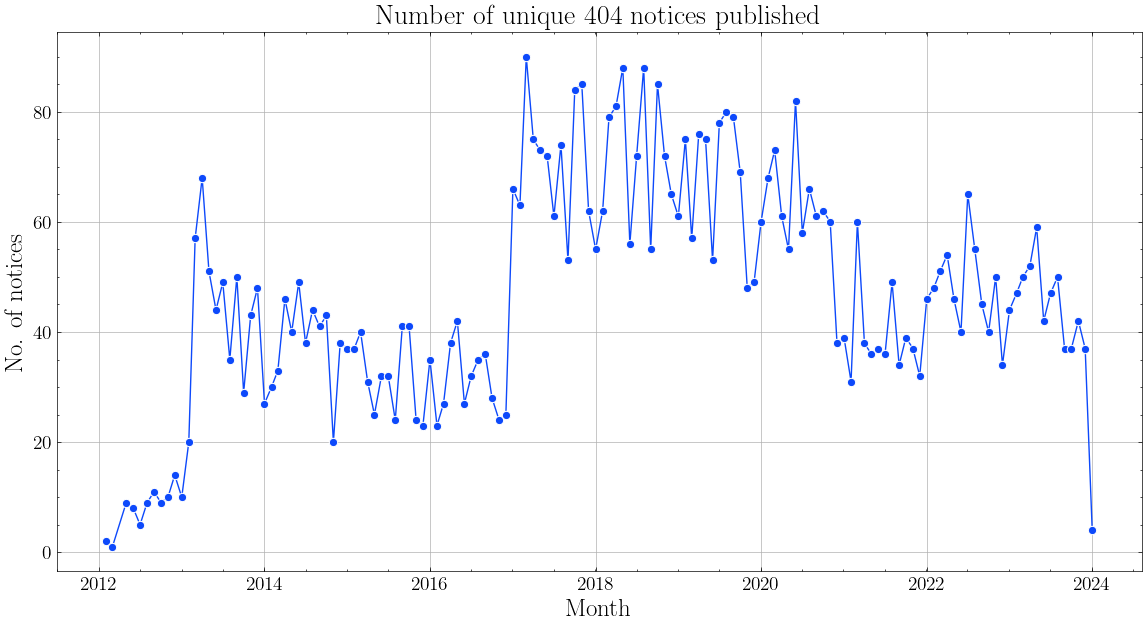

In [8]:
# Example usage:
grouped_df = prepare_time_series(val_df, time='month', variable='n_notices', smoothing_param=None)
grouped_df['time_group'] = grouped_df['time_group'].dt.to_timestamp()

# sns.set_context('paper')
# plt.figure(figsize=(14, 7))
# ax = sns.lineplot(data=grouped_df, x='time_group', y='n_notices', marker='o', label='n_notices')
# plt.xlabel('Month')
# plt.ylabel('No. of notices')
# plt.title('Number of unique 404 notices published')
# plt.legend()
# plt.grid(True);
# Using the 'science' style for the plot
with plt.style.context(['science', 'high-vis']):
    plt.figure(figsize=(14, 7))
    plt.rcParams['axes.labelsize'] = 18
    plt.rcParams['axes.titlesize'] = 20
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
#     plt.rcParams['legend.title_fontsize'] = 18
#     plt.rcParams['legend.fontsize'] = 16    
    ax = sns.lineplot(data=grouped_df, x='time_group', y='n_notices', marker='o')

    plt.xlabel('Month')
    plt.ylabel('No. of notices')
    plt.title('Number of unique 404 notices published')
#     plt.legend()
    plt.grid(True)
    plt.show()

### 2. Smoothed plot with rolling averages

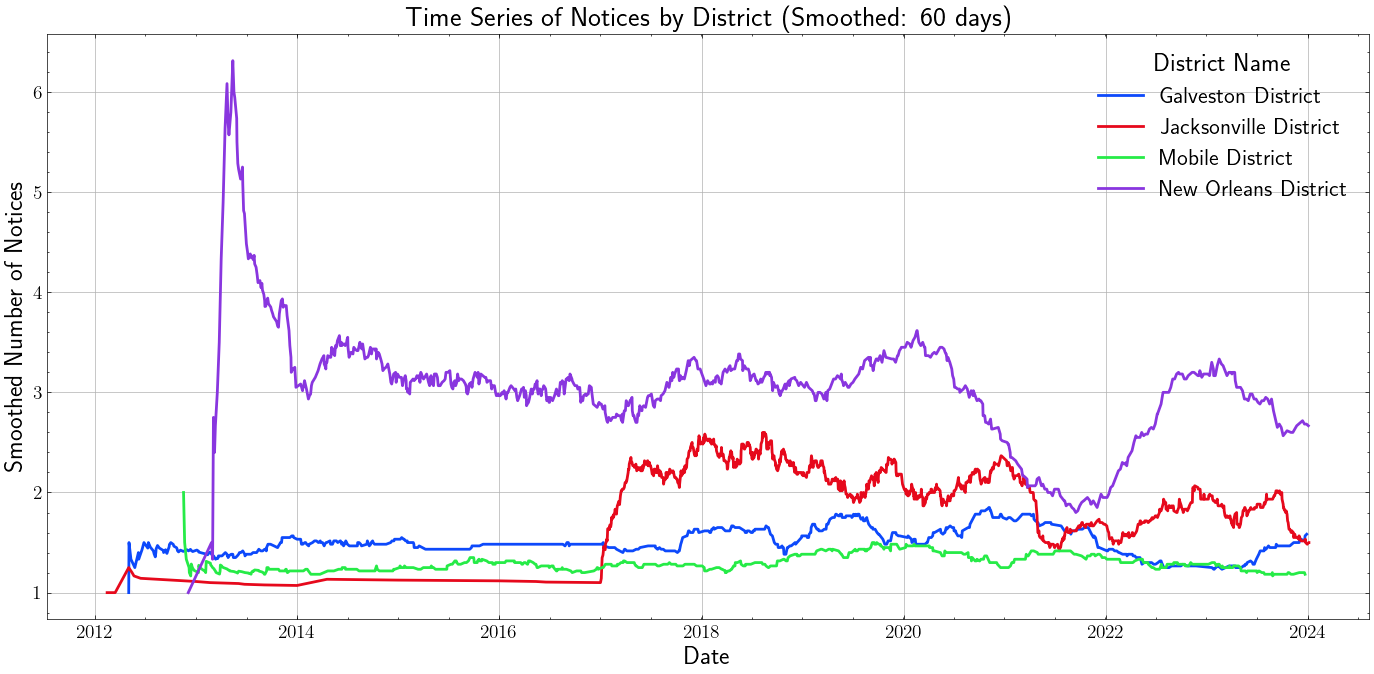

In [25]:

### Rolling average plot
def plot_smoothed_notices(df, window_size, unit):
    # Preprocess
    df_dist = df.groupby(['pdf_districtName', 'date'])['noticeID'].nunique().reset_index(name='n_notices')
    df_dist = df_dist[~df_dist.pdf_districtName.str.contains('error', case=False)]

    # Convert date
    df_dist['date'] = pd.to_datetime(df_dist['date'])
    if unit == 'month':
        df_dist['date'] = df_dist['date'].dt.to_period('M').dt.to_timestamp()

    # Apply rolling window
    df_dist['smoothed_n_notices'] = df_dist.groupby('pdf_districtName')['n_notices'].transform(
        lambda x: x.rolling(window_size, min_periods=1).mean())
    
    
#     with plt.style.context('Solarize_Light2'): #['science', 'high-vis']
    with plt.style.context(['science', 'high-vis']): #['science', 'high-vis']

        # Plot
        plt.figure(figsize=(14, 7))
        plt.rcParams['axes.labelsize'] = 18
        plt.rcParams['axes.titlesize'] = 20
        plt.rcParams['xtick.labelsize'] = 14
        plt.rcParams['ytick.labelsize'] = 14
        plt.rcParams['legend.title_fontsize'] = 18
        plt.rcParams['legend.fontsize'] = 16
        # Set font properties using rcParams
        plt.rcParams['font.family'] = 'sans-serif'  # Set the font family (e.g., 'serif', 'sans-serif', 'monospace')
        plt.rcParams['font.size'] = 12             # Set the global font size
        plt.rcParams['font.weight'] = 'normal'     # Set the font weight ('normal', 'bold', etc.)
        plt.grid(True)

        sns.lineplot(data=df_dist, x='date', y='smoothed_n_notices', linewidth=2, hue='pdf_districtName')
        plt.xlabel('Date')
        plt.ylabel('Smoothed Number of Notices')
        plt.title(f'Time Series of Notices by District (Smoothed: {window_size} {unit}s)')
        plt.legend(title='District Name')
        plt.tight_layout()
        plt.show()

# Example usage
plot_smoothed_notices(val_df, 60, 'day')


### 3. Fill in missing time periods

In [10]:

grouped_df = prepare_time_series(val_df, time='month', variable='n_notices', smoothing_param=None)
grouped_df['time_group'] = grouped_df['time_group'].dt.to_timestamp().dt.to_period('M')

# Determine the start and end dates for the range
start_date = grouped_df['time_group'].min()
end_date = grouped_df['time_group'].max()

# Create a complete range of monthly periods
complete_months = pd.period_range(start=start_date.to_timestamp(), end=end_date.to_timestamp(), freq='M')

# Set 'time_group' as the datetime index and ensure it is applied to the DataFrame
grouped_df.set_index('time_group', inplace=True)

# Reindex the DataFrame with the complete range and fill missing values with zero
grouped_df = grouped_df.reindex(complete_months)

#fill missing with 0
grouped_df.fillna(0, inplace=True)

# Display the DataFrame
grouped_df.head()
# grouped_df.interpolate().reindex()



,n_notices
2012-02,2.0
2012-03,1.0
2012-04,0.0
2012-05,9.0
2012-06,8.0


### 4. Seasonal decomposition

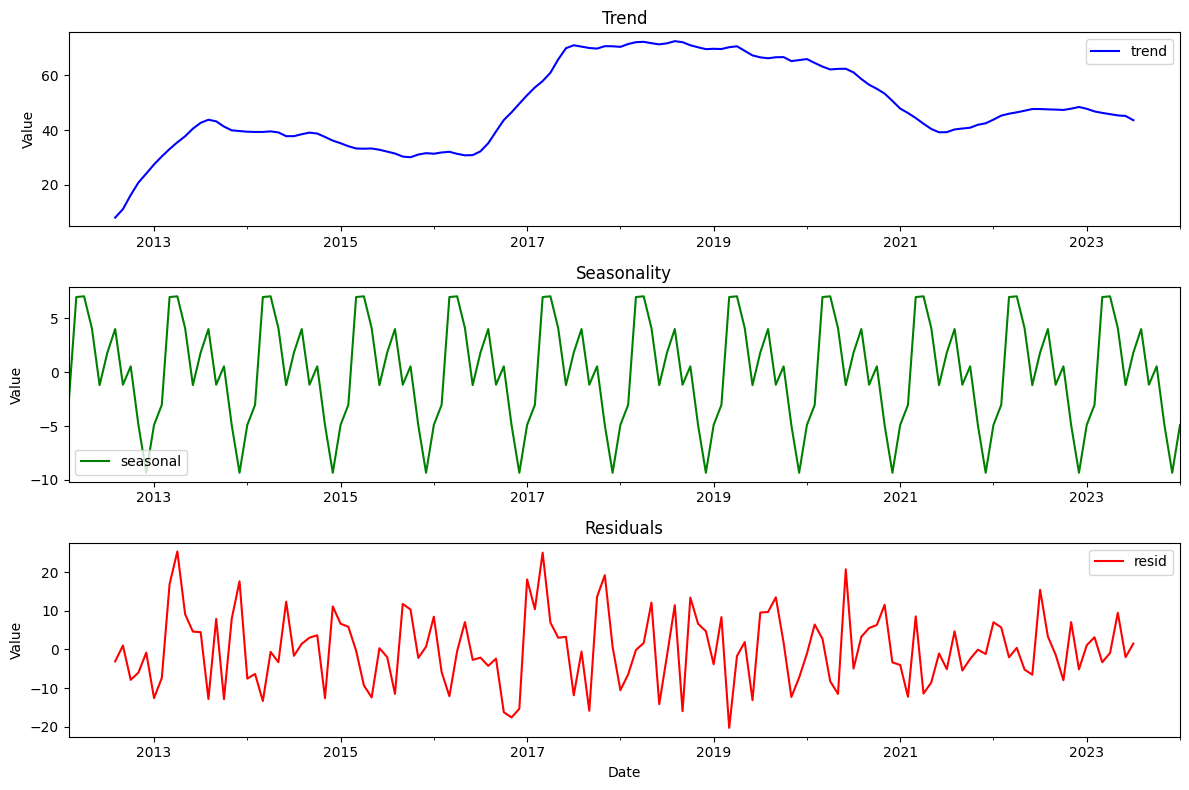

In [11]:


# Convert the PeriodIndex to a DatetimeIndex with defined frequency
grouped_df.index = grouped_df.index.to_timestamp(freq='M')

# Decomposition with an 'additive' model
decomposition = sm.tsa.seasonal_decompose(grouped_df['n_notices'], model='additive')


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))

# Plotting Trend
decomposition.trend.plot(ax=ax1, color='blue', legend=True)
ax1.set_title('Trend')
ax1.set_ylabel('Value')
ax1.tick_params(axis='both', which='major', labelsize=10)

# Plotting Seasonality
decomposition.seasonal.plot(ax=ax2, color='green', legend=True)
ax2.set_title('Seasonality')
ax2.set_ylabel('Value')
ax2.tick_params(axis='both', which='major', labelsize=10)

# Plotting Residuals
decomposition.resid.plot(ax=ax3, color='red', legend=True)
ax3.set_title('Residuals')
ax3.set_ylabel('Value')
ax3.set_xlabel('Date')
ax3.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show();


### Interpret:

- **Trend**: The top plot shows the 'Trend' component of your time series data. The trend component represents the long-term progression of the series — in other words, it smooths out the shorter-term fluctuations to highlight the overall direction (upward, downward, or stationary) over time. In your case, the trend increases slightly until around 2018 and then starts to level off towards the end of the series. Notices issued were rising over time until 2018, where it reached a plateau or a period of little to no growth.

- **Seasonality**: The middle plot shows the 'Seasonality' component. This captures the regular patterns of variability within the time series data that occur at specific known intervals — often daily, weekly, monthly, or quarterly. The consistent up-and-down pattern in your plot indicates a regular seasonal effect within the time series. The magnitude of the seasonal fluctuations appears relatively constant over time

- **Residual**: The bottom plot displays the 'Residuals' component, which represents the noise or random variation that cannot be explained by the trend or seasonal components. Ideally, you want the residuals to appear as random white noise, indicating that all the systematic information (trend and seasonality) has been captured by the model.




### 5. Statistical test: Structural break

In [12]:
# Function to perform Chow Test
def chow_test(data, break_point):
    data_before = data[:break_point]
    data_after = data[break_point:]
    
    X_before = sm.add_constant(range(len(data_before)))
    X_after = sm.add_constant(range(len(data_after)))
    X = sm.add_constant(range(len(data)))
    
    model_before = sm.OLS(data_before, X_before).fit()
    model_after = sm.OLS(data_after, X_after).fit()
    model_combined = sm.OLS(data, X).fit()
    
    # Chow Test Formula
    num = (model_combined.ssr - (model_before.ssr + model_after.ssr)) / 2
    denom = (model_before.ssr + model_after.ssr) / (len(data) - 4)
    F = num / denom
    return F


In [24]:
val_df.columns

Index(['web_title', 'usaceWebUrl', 'datePublished', 'dateExpiry', 'PdfUrl',
       'web_applicant', 'web_location', 'web_character', 'web_mitigation',
       'web_text', 'specialFlag', 'pdf_comment_window', 'usacePermitNumber',
       'pdf_districtCode', 'pdf_districtName_x', 'name', 'phone', 'email',
       'applicantDetails', 'applicantCompanyName', 'applicantContractorName',
       'pdf_location', 'pdf_longitude', 'pdf_latitude', 'pdf_county',
       'pdf_parish', 'pdf_city', 'pdf_character_x', 'pdf_mitigation',
       'hydrologicUnitCode', 'pdf_wqc', 'pdf_cup', 'pdf_impact',
       'pdf_full_text', 'pdf_text_flag', 'noticeID', 'wetland_llm_dict',
       'level_0', 'index', 'wetland_llm_dict_str', 'wetland_llm_dict_missing',
       'date', 'pdf_character_y', 'tokens', 'project_detail',
       'total_project_area', 'project_category', 'proj', 'oil_gas',
       'impact_type', 'impact_duration', 'pdf_districtName_y',
       'impact_quantity_acre', 'clean_wetland', 'year', 'wet_loss'],


In [13]:
# merge with 2020-2024 wetland+embedding data
wet_emb = pd.read_parquet('wet_loss_emb_all.parquet')

# val_df=val_df.merge(wet_emb, on='noticeID', how='left')


<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

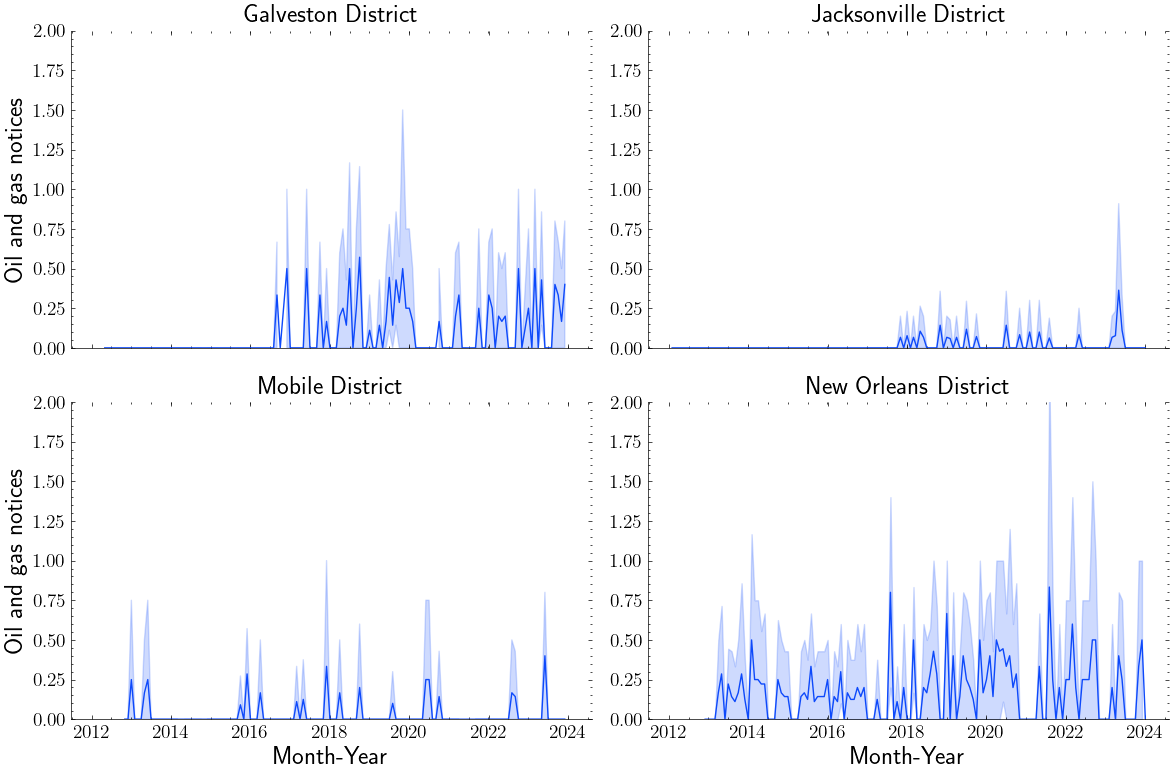

In [23]:

# column to denote confirmed wetland losss 
val_df['wet_loss'] = val_df['noticeID'].isin(wet_emb.noticeID).astype(int)

val_df['oil_gas'] = val_df['noticeID'].isin(wet_emb[wet_emb.oil_gas==1].noticeID).astype(int)
# preprocess
grouped_df = val_df.groupby(['pdf_districtName', 'date'])['oil_gas'].sum().reset_index(name='oil_gas')

# grouped_df['month_year'] = pd.to_datetime(grouped_df['time_group'])
grouped_df = grouped_df[~grouped_df.pdf_districtName.str.contains('error', case=False)]

grouped_df['month_year'] = grouped_df['date'].dt.to_period('M')

grouped_df['month_year'] = grouped_df['month_year'].dt.to_timestamp()

with plt.style.context(['science', 'high-vis']): #['science', 'high-vis']

    # Plot
    plt.figure(figsize=(14, 7))
    plt.rcParams['axes.labelsize'] = 18
    plt.rcParams['axes.titlesize'] = 20
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    plt.rcParams['legend.title_fontsize'] = 18
    plt.rcParams['legend.fontsize'] = 16
    # Set font properties using rcParams
    plt.rcParams['font.family'] = 'sans-serif'  # Set the font family (e.g., 'serif', 'sans-serif', 'monospace')
    plt.rcParams['font.size'] = 12             # Set the global font size
    plt.rcParams['font.weight'] = 'normal'     # Set the font weight ('normal', 'bold', etc.)

    # Plot with Chow Test results
    g = sns.FacetGrid(grouped_df, col='pdf_districtName', col_wrap=2, height=4, aspect=1.5, sharey=False)
    g.map_dataframe(sns.lineplot, x='month_year', y='oil_gas')

#     for ax, (name, group) in zip(g.axes.flat, grouped_df.groupby('pdf_districtName')):
#         n = len(group)
#         break_point = n // 2
#         F_stat = chow_test(group['oil_gas'].values, break_point)
#         break_date = group.iloc[break_point]['month_year']

#         # Calculate mean values before and after break point
#         mean_before = group['oil_gas'].iloc[:break_point].mean()
#         mean_after = group['oil_gas'].iloc[break_point:].mean()
#         effect = mean_after - mean_before

#         # Plotting the break point
#         ax.axvline(break_date, color='red', linestyle='--', lw=1)
#         ax.text(break_date, ax.get_ylim()[1]*0.9,
#                 f'Break - {break_date.strftime("%b-%Y")}\nEffect: {effect:.2f}', color='red', 
#                 rotation=0)
    # Set the same y-axis limits for all plots
    max_y = grouped_df['oil_gas'].max()
    g.set(ylim=(0, 2))  # Set the minimum to 0 and maximum to the max value in 'oil_gas'

    g.set_axis_labels('Month-Year', 'Oil and gas notices')
    g.set_titles(col_template="{col_name}")

    plt.tight_layout()
    plt.show();


<Figure size 1400x700 with 0 Axes>

Text(2018-08-01 00:00:00, 6.57, 'Break - Aug-2018\nEffect: 0.09')

Text(2020-01-01 00:00:00, 3.973218749999998, 'Break - Jan-2020\nEffect: -0.37')

Text(2018-06-01 00:00:00, 3.7350000000000003, 'Break - Jun-2018\nEffect: 0.06')

Text(2017-07-01 00:00:00, 10.826437499999997, 'Break - Jul-2017\nEffect: -0.31')

<Figure size 1400x700 with 0 Axes>

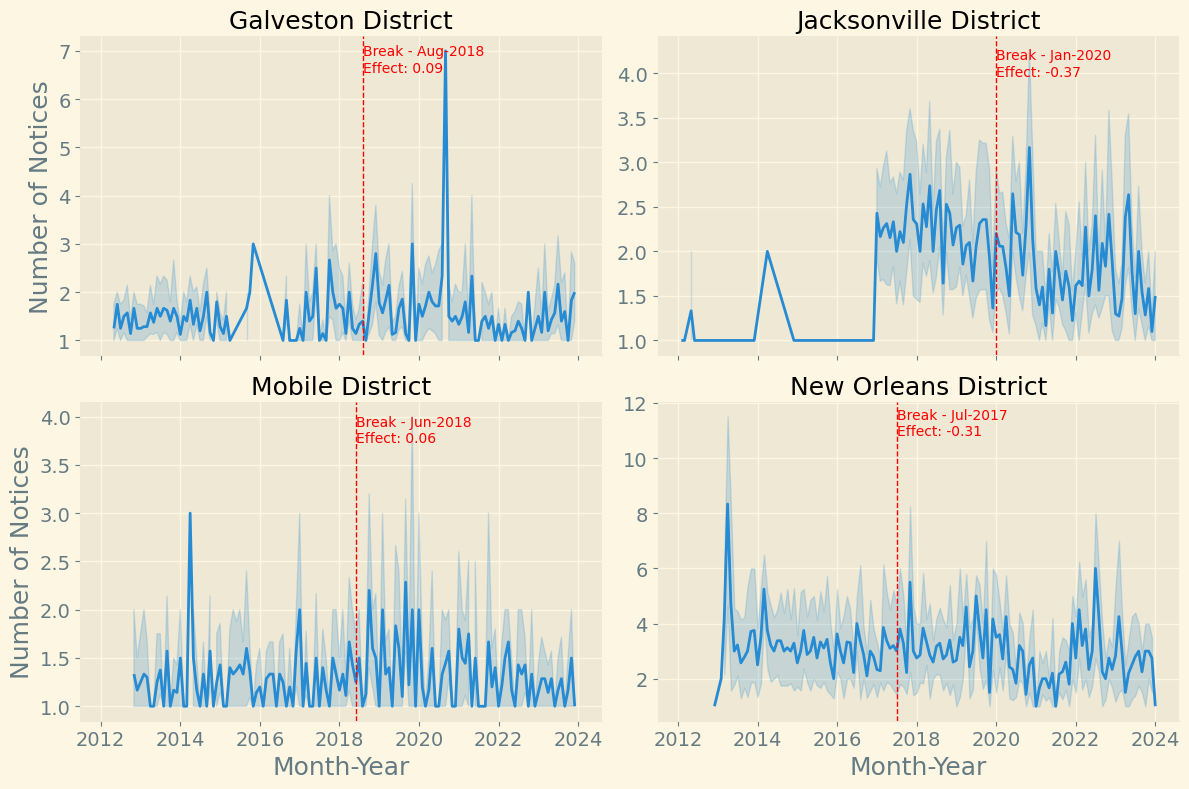

In [52]:


# preprocess
grouped_df = val_df.groupby(['pdf_districtName', 'date'])['noticeID'].nunique().reset_index(name='n_notices')

# grouped_df['month_year'] = pd.to_datetime(grouped_df['time_group'])
grouped_df = grouped_df[~grouped_df.pdf_districtName.str.contains('error', case=False)]

grouped_df['month_year'] = grouped_df['date'].dt.to_period('M')

grouped_df['month_year'] = grouped_df['month_year'].dt.to_timestamp()

with plt.style.context('Solarize_Light2'): #['science', 'high-vis']

    # Plot
    plt.figure(figsize=(14, 7))
    plt.rcParams['axes.labelsize'] = 18
    plt.rcParams['axes.titlesize'] = 20
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    plt.rcParams['legend.title_fontsize'] = 18
    plt.rcParams['legend.fontsize'] = 16

    # Plot with Chow Test results
    g = sns.FacetGrid(grouped_df, col='pdf_districtName', col_wrap=2, height=4, aspect=1.5, sharey=False)
    g.map_dataframe(sns.lineplot, x='month_year', y='n_notices')

    for ax, (name, group) in zip(g.axes.flat, grouped_df.groupby('pdf_districtName')):
        n = len(group)
        break_point = n // 2
        F_stat = chow_test(group['n_notices'].values, break_point)
        break_date = group.iloc[break_point]['month_year']

        # Calculate mean values before and after break point
        mean_before = group['n_notices'].iloc[:break_point].mean()
        mean_after = group['n_notices'].iloc[break_point:].mean()
        effect = mean_after - mean_before

        # Plotting the break point
        ax.axvline(break_date, color='red', linestyle='--', lw=1)
        ax.text(break_date, ax.get_ylim()[1]*0.9,
                f'Break - {break_date.strftime("%b-%Y")}\nEffect: {effect:.2f}', color='red', 
                rotation=0)

    g.set_axis_labels('Month-Year', 'Number of Notices')
    g.set_titles(col_template="{col_name}")

    plt.tight_layout()
    plt.show();



https://kevin-kotze.gitlab.io/tsm/ts-2-slide/#3

### 6. Statistical test: Change-Point Detection in Time Series Data

The goal of change-point detection is to identify points in time at which the statistical properties of a time series change significantly. These points are known as 'change points' or 'breakpoints'. In practical terms, change points can signify shifts in behavior, trends, or underlying processes governing the data.

Consider a time series $ \{X_t\} $ for $ t = 1, 2, ..., T $, where $ T $ is the length of the series.

The objective is to find change points $ \{ \tau_1, \tau_2, ..., \tau_k \} $ where the statistical properties (like mean, variance) of segments defined by these points differ. The time series is assumed to follow a certain statistical model within each segment. For example, in each segment, the data could follow a normal distribution with constant mean and variance.

**Change-Point Detection Algorithms:** (details in appendix)

The goal is to minimize a cost function $ C $, which often is a trade-off between the goodness of fit within segments and the number of segments. Mathematically, this can be expressed as:
     $$
     \min \sum_{i=1}^{m+1} \text{Cost}(X_{\tau_{i-1}+1:\tau_i}) + \beta \cdot m
     $$

Here, $ X_{\tau_{i-1}+1:\tau_i} $ represents the data in the $ i $-th segment, $ \text{Cost} $ is the cost function for a segment, $ m $ is the number of segments, and $ \beta $ is a penalty term for the number of segments.

Detected change points $ \{ \tau_1, \tau_2, ..., \tau_k \} $ split the time series into segments where each segment is assumed to follow the model more closely than the entire series.

- Algorithms:

    - `Binseg`: Binary Segmentation, good for multiple change points.
    - `BottomUp`: Bottom-up segmentation, merges segments iteratively.
    - `Window`: Sliding-window-based method, good for abrupt changes.
    - `Dynp`: Dynamic programming approach, computationally intensive but exact.

- Cost Functions:

    - `"linear"`: Detects changes in mean in a univariate signal.
    - `"normal"`: Assumes a Gaussian distribution of the signal.
    - `"mahalanobis"`: For multivariate signals, considering covariance.
    - `"rank"`: Based on rank statistics, useful for non-parametric models.
   

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Value')

Text(0.5, 1.0, 'Change-Point Analysis with Colored Patches')

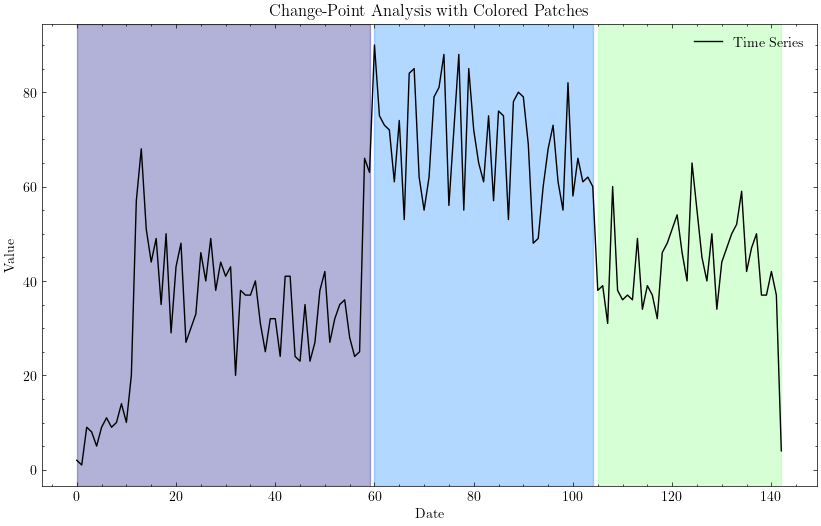

In [37]:


# Assuming 'grouped_df' and 'n_notices' are your DataFrame and time series column

# Convert your series to a numpy array for ruptures
data = grouped_df['n_notices'].values

# Change-point detection
model = "rbf"  # Choose a model type, e.g., "l1", "l2", "rbf"
algo = rpt.Pelt(model=model).fit(data)
# bkps = algo.predict(n_bkps=3)
bkps = algo.predict(pen=13) # this is equal to the above

with plt.style.context(['science', 'high-vis']):

    # Creating the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(grouped_df.index, data, label='Time Series', color='black')

    # Adding colored patches
    bkps = [0] + bkps  # Adding the start of the series
    for i in range(len(bkps) - 1):
        start, end = bkps[i], bkps[i+1]
        ax.add_patch(mpatches.Rectangle((grouped_df.index[start], ax.get_ylim()[0]), 
                                        grouped_df.index[end-1] - grouped_df.index[start], 
                                        ax.get_ylim()[1] - ax.get_ylim()[0],
                                        color=plt.cm.jet(i / len(bkps)), alpha=0.3))

    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Change-Point Analysis with Colored Patches')
    plt.legend()
    plt.show();




## ---------------------------------------------------------------------------------------------------------------------------

## Wetland Impact analysis (2020-2023)


Read in the cleaned wetland_impacts file (from the LLM evaluation notebook).

In [5]:
wet_impacts = pd.read_parquet('wetland_impact_df_20.parquet')